In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [130]:
# loading data
test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')

In [131]:
# imbalanced classes (but not too much)
print(f'{train_data[target_col].mean() * 100:.1f}% class 1 (target)')

26.2% class 1 (target)


In [132]:
# no missing values in categorical features
test_cat_na = test_data[cat_cols].isna().sum().sum()
train_cat_na = train_data[cat_cols].isna().sum().sum()
print(f'cat_cols_na: {train_cat_na}, {test_cat_na} (train, test)')

cat_cols_na: 0, 0 (train, test)


In [133]:
# Numerical Features (train)
# TotalSpent: wrong dtype
# TotalSpent: 9 missing values
# ClientPeriod: 9 zeros (missing values)
data = train_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,9
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,9,0


In [134]:
# Numerical Features (test)
# TotalSpent: wrong dtype
# TotalSpent: 2 missing values
# ClientPeriod: 2 zeros (missing values)
data = test_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,2
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,2,0


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,2920,18.147603,12,1,17.684934,0,0
One year,1082,41.929760,44,53,18.891057,0,1
Two year,1280,56.845312,65,72,18.291818,0,8


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,955,17.697382,12,1,17.706599,0,0
One year,391,42.363171,44,69,19.452007,0,0
Two year,415,56.395181,63,72,17.970265,0,2


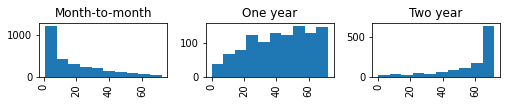

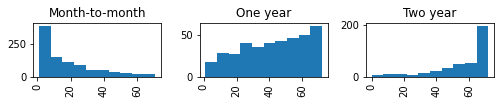

In [135]:
# ClientPeriod: choosing strategy for filling zeros
# 'HasContractPhone': min std within groups
# We can fill missing values with median of each group
def na(x): return x.isnull().sum()
def zero(x): return (x == 0).sum()
def mode(x): return x.value_counts().index[0]
agg_funcs = ('size','mean','median',mode,'std',na,zero)
display(train_data.groupby('HasContractPhone')['ClientPeriod'].agg(agg_funcs))
display(test_data.groupby('HasContractPhone')['ClientPeriod'].agg(agg_funcs))
train_data.hist(column='ClientPeriod', by='HasContractPhone', layout=(1,3), figsize=(8,1))
test_data.hist(column='ClientPeriod', by='HasContractPhone', layout=(1,3), figsize=(8,1));

In [136]:
def check_filling_zeros(data):
    # x.mean(), x.median(), stats.mode(x)[0][0]
    replace = lambda x: x.replace(0, x.median())
    idx = data[data['ClientPeriod'] == 0].index
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace)
    display(data.loc[idx,['ClientPeriod','HasContractPhone']])

In [140]:
# ClientPeriod: checking strategy (train)
check_filling_zeros(train_data.copy())

,ClientPeriod,HasContractPhone
1048,65.0,Two year
1707,65.0,Two year
2543,44.0,One year
3078,65.0,Two year
3697,65.0,Two year
4002,65.0,Two year
4326,65.0,Two year
4551,65.0,Two year
4598,65.0,Two year


In [139]:
# ClientPeriod: checking strategy (test)
check_filling_zeros(test_data.copy())

,ClientPeriod,HasContractPhone
177,63.0,Two year
767,63.0,Two year


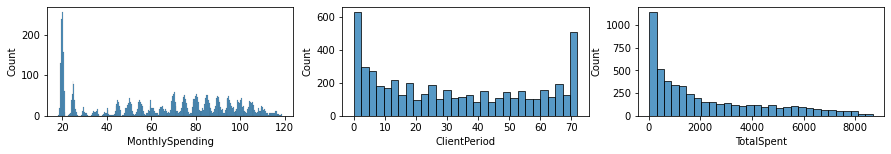

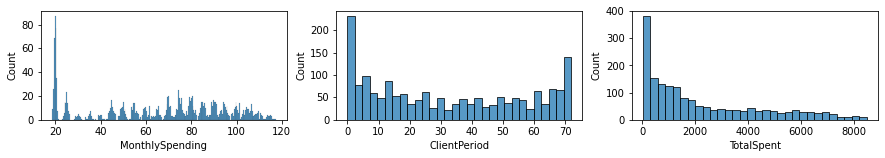

In [153]:
# MonthlySpending: multimodal normal distribution
# We can cut this feature accordingly into bins

def show_num_distributions(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    fig, axes = plt.subplots(1,3,figsize=(15,2))
    sns.histplot(data['MonthlySpending'], bins=250, ax=axes[0])
    sns.histplot(data['ClientPeriod'], bins=30, ax=axes[1])
    sns.histplot(data['TotalSpent'], bins=30, ax=axes[2]);

show_num_distributions(train_data.copy())
show_num_distributions(test_data.copy())

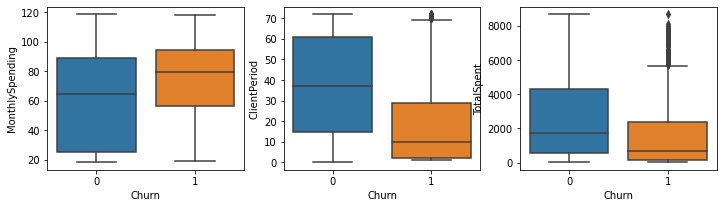

In [117]:
# Looking for outliers
# ClientPeriod: there are some (Churn = 1)
# TotalSpent: there are some (Churn = 1)
fig, axes = plt.subplots(1,3,figsize=(12,3))
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
sns.boxplot(x='Churn', y='MonthlySpending', data=train_data, ax=axes.flat[0])
sns.boxplot(x='Churn', y='ClientPeriod', data=train_data, ax=axes.flat[1])
sns.boxplot(x='Churn', y='TotalSpent', data=train_data, ax=axes.flat[2]);

In [106]:
def check_outliers(c):
    Q1 = c.quantile(0.25)
    Q3 = c.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    print(f'Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}')
    print(f'low: {low:.2f}, high: {high:.2f}')
    print(f'outliers: {((c < low) | (c > high)).sum()}')

In [113]:
check_outliers(train_data[train_data['Churn'] == 1]['ClientPeriod'])

Q1: 2.00, Q3: 29.00, IQR: 27.00
low: -38.50, high: 69.50
outliers: 18


In [104]:
check_outliers(train_data[train_data['Churn'] == 1]['TotalSpent'])

Q1: 134.65, Q3: 2352.55, IQR: 2217.90
low: -3192.20, high: 5679.40
outliers: 74


In [110]:
train_data[(train_data['ClientPeriod'] > 69.5) & (train_data['Churn'] == 1)].shape

(18, 20)

In [111]:
train_data[(train_data['TotalSpent'] > 5679.4) & (train_data['Churn'] == 1)].shape

(74, 20)